In [13]:
# SiFi-NN trained on the simulation with continuous source then evaluated on 
# the Bragg containing simulation
import numpy as np
import uproot
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.keras.backend as K

from sificc_lib import AI, utils, Event, Simulation, root_files, DataModel
np.set_printoptions(precision=2, linewidth=85, suppress=True)

%matplotlib inline

In [2]:
# The main AI trained on all the data of the new simulation
model_name = 'model-lsr-cont'

shuffle_clusters = False

# load the training data
data = DataModel('data-cont-top-8.npz', 
                 batch_size = 128, validation_percent = .05, test_percent = .05, 
                 weight_compton=1, weight_non_compton=1)

# append an extra dimention to the features since we are using convolutional layers
data.append_dim = True

# create an AI instance
ai = AI(data, model_name)

ai.weight_type = 1.4
ai.weight_pos_x = 2.5
ai.weight_pos_y = .5
ai.weight_pos_z = 2
ai.weight_energy = .8
ai.weight_e_cluster = .6
ai.weight_p_cluster = .4

# shuffle the clusters within each event
if shuffle_clusters:
    ai.data.shuffle_training_clusters()

In [4]:
# define and create the neural network architecture
ai.create_model(conv_layers=[128, 64], classifier_layers=[32], type_layers=[16, 8], 
                pos_layers=[64,32], energy_layers=[32, 16], base_l2=.0001, limbs_l2=.0001)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 72, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 8, 128)       1280        inputs[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 8, 64)        8256        conv_1[0][0]                     
__________________________________________________________________________________________________
flatting (Flatten)              (None, 512)          0           conv_2[0][0]                     
____________________________________________________________________________________________

In [5]:
# compile the ai
ai.compile_model(learning_rate=0.003)

# define the learning rate scheduler for the training phase
def lr_scheduler(epoch):
    if epoch < 60:
        return .003
    elif epoch < 110:
        return .001
    elif epoch < 140:
        return .0003
    elif epoch < 165:
        return .0001
    elif epoch < 185:
        return .00003
    elif epoch < 195:
        return .00001
    else:
        return .000003
l_callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler),
]

In [6]:
# #LOADING
# ai.data = DataModel('data-mtx-top-8.npz', 
#                  batch_size = 128, validation_percent = .1, test_percent = .3, 
#                  weight_compton=1, weight_non_compton=1)
# ai.data.append_dim = True
# ai.load(model_name, optimizer=False)
# ai.compile_model()

In [6]:
#TRAINING

In [7]:
%%time
# balance the training data since there are too many background events
ai.data.balance_training = True

# start the training
ai.train(epochs=200, shuffle_clusters=shuffle_clusters, verbose=0, callbacks = l_callbacks)

# evaluate the AI on the training set
ai.model.evaluate(ai.data.train_x, ai.data.train_y, verbose=1)
print()

6983/6983 [==============================] - 12s 2ms/step - loss: 5.5790 - e_cluster_loss: 0.0459 - p_cluster_loss: 0.1641 - type_loss: 0.4328 - pos_x_loss: 0.1740 - pos_y_loss: 3.7442 - pos_z_loss: 0.0681 - energy_loss: 2.8930 - e_cluster__cluster_accuracy: 0.9645 - p_cluster__cluster_accuracy: 0.8662 - type__type_accuracy: 0.8019 - type__type_tp_rate: 0.8415

CPU times: user 6h 38min 18s, sys: 2min 7s, total: 6h 40min 26s
Wall time: 6h 44min 29s


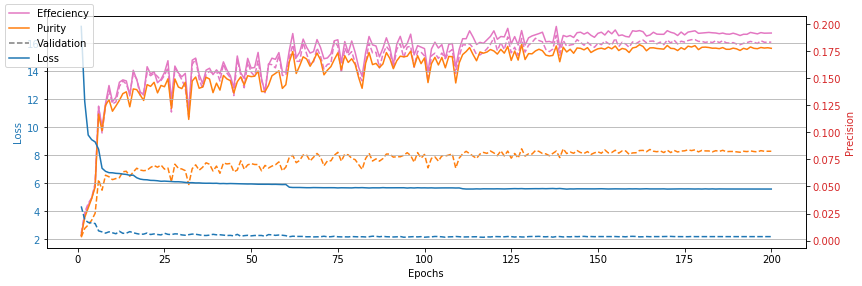

In [8]:
# plot the training loss
ai.plot_training_loss(smooth=False)

In [9]:
# evaluate the AI on the test dataset
ai.evaluate()

AI model
  Loss:        2.17190
    -Type:         0.44635 *  1.40 = 0.62489
    -Pos X:        0.04579 *  2.50 = 0.11447
    -Pos Y:        1.11014 *  0.50 = 0.55507
    -Pos Z:        0.02200 *  2.00 = 0.04400
    -Energy:       0.85343 *  0.80 = 0.68275
    -Cls e:        0.01525 *  0.60 = 0.00915
    -Cls p:        0.04859 *  0.40 = 0.01944
  Accuracy:     0.77495
    -Precision:    0.37512
    -Recall:       0.83537
    -Cls e rate:   0.95973
    -Cls p rate:   0.86501
  Efficiency:   0.19362
  Purity:       0.08694
  Euc mean:    11.27563
  Euc std:     18.17045
  Energy mean:  0.31195
  Energy std:   0.74586

Reco
  Accuracy:     0.68932
    -Recall:       0.67155
  Efficiency:   0.12436
  Purity:       0.04991
  Euc mean:    12.34355
  Euc std:     18.71795
  Energy mean:  0.44726
  Energy std:   0.93658


In [16]:
# evaluate the AI on the dataset with Bragg peak
ai.data = DataModel('data-mtx-top-8.npz', 
                 batch_size = 128, validation_percent = .1, test_percent = .4, 
                 weight_compton=1, weight_non_compton=1)
ai.data.append_dim = True
ai.type_threshold = .5
ai.evaluate()

AI model
  Loss:        2.43728
    -Type:         0.42864 *  1.40 = 0.60010
    -Pos X:        0.06306 *  2.50 = 0.15764
    -Pos Y:        1.17162 *  0.50 = 0.58581
    -Pos Z:        0.02580 *  2.00 = 0.05161
    -Energy:       1.11039 *  0.80 = 0.88831
    -Cls e:        0.01803 *  0.60 = 0.01082
    -Cls p:        0.05214 *  0.40 = 0.02086
  Accuracy:     0.78983
    -Precision:    0.43266
    -Recall:       0.83122
    -Cls e rate:   0.95865
    -Cls p rate:   0.87297
  Efficiency:   0.19415
  Purity:       0.10106
  Euc mean:    10.75421
  Euc std:     18.58468
  Energy mean:  0.34909
  Energy std:   0.82284

Reco
  Accuracy:     0.65981
    -Recall:       0.76909
  Efficiency:   0.13441
  Purity:       0.05219
  Euc mean:    11.79185
  Euc std:     19.09710
  Energy mean:  0.49799
  Energy std:   1.00702


In [15]:
# evaluate the AI on the dataset with Bragg peak with a higher threshold
ai.type_threshold = .8
ai.evaluate()

AI model
  Loss:        2.43728
    -Type:         0.42864 *  1.40 = 0.60010
    -Pos X:        0.06306 *  2.50 = 0.15764
    -Pos Y:        1.17162 *  0.50 = 0.58581
    -Pos Z:        0.02580 *  2.00 = 0.05161
    -Energy:       1.11039 *  0.80 = 0.88831
    -Cls e:        0.01803 *  0.60 = 0.01082
    -Cls p:        0.05214 *  0.40 = 0.02086
  Accuracy:     0.78983
    -Precision:    0.56894
    -Recall:       0.43218
    -Cls e rate:   0.95865
    -Cls p rate:   0.87297
  Efficiency:   0.09026
  Purity:       0.11882
  Euc mean:    12.21119
  Euc std:     19.82262
  Energy mean:  0.25745
  Energy std:   0.66812

Reco
  Accuracy:     0.65981
    -Recall:       0.76909
  Efficiency:   0.13441
  Purity:       0.05219
  Euc mean:    11.79185
  Euc std:     19.09710
  Energy mean:  0.49799
  Energy std:   1.00702


In [12]:
ai.export_predictions_root(f'sificc-nnq-llr-0mm-shift.root')

In [8]:
# save the trained model
ai.save(file_name=model_name)